In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import matplotlib as mpl    
import seaborn as sns

mpl.rc('font',family='serif')

import pickle


/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# pkl_file = open('xgboost_dict_of_dicts.pkl', 'rb')
# dict_of_dicts = pickle.load(pkl_file)
# pkl_file.close()

pkl_file = open('new_test_df.pkl', 'rb')
df_test = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('new_train_df.pkl', 'rb')
df_train = pickle.load(pkl_file)
pkl_file.close()

df_test['binary_best'] = (df_test['best']>0)+0
df_train['binary_best']  = (df_train['best']>0)+0

pkl_file = open('xgboost_dict_of_dicts_new.pkl', 'rb')
dict_of_dicts = pickle.load(pkl_file)
pkl_file.close()

# so you test robustness v. 3 (maybe 4) baselines:
- last obs
- conflict ratio
- cm_mean
- (exponetially weighted average)

In [3]:
from sklearn.metrics import f1_score, average_precision_score, brier_score_loss

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
def logit(z):
    a = 1/(1+np.exp(-z))
    
    return(a)

def baysian_correction(a):
    
    ones = df_train['binary_best'].sum()/df_train['binary_best'].shape[0]
    zeroes = 1 - (df_train['binary_best'].sum()/df_train['binary_best'].shape[0])
    
    y_hat =  (a*ones)/((a*ones)+((1-a)*zeroes))
    return(y_hat)

In [5]:
def get_baselines():
    
    # true y:
    y = df_test[['binary_best','year']]
    
    # baseline last obs
    baseline_lastObs = df_train[df_train['year']==2012]['binary_best']
    baseline_lastObs.name = 'baseline_lastObs'

    # baseline conflcit ratio
    baseline_ratio = df_train.groupby('gid').mean()['binary_best']
    baseline_ratio.name = 'baseline_ratio'
    
    # baseline cm
    cm_mu = df_test['cm_mu']
    logit_cm_mu = logit(cm_mu)
    bayes_cm_mu = baysian_correction(logit_cm_mu)
    baseline_cm = pd.DataFrame([bayes_cm_mu,df_test['year']]).T
    baseline_cm.columns = ['baseline_cm','year']
    
    return(y, baseline_lastObs, baseline_ratio, baseline_cm)

In [6]:
y, baseline_lastObs, baseline_ratio, baseline_cm = get_baselines()

In [14]:
def get_metrics(y, baseline_lastObs, baseline_ratio, baseline_cm, threshold = 0.1):
    
    lastObs_f1 = []
    ratio_f1 = []
    cm_f1 = []
    full_f1 = []
    
    lastObs_ap = []
    ratio_ap = []
    cm_ap = []
    full_ap = []
    
    lastObs_brier = []
    ratio_brier = []
    cm_brier = []
    full_brier = []
    
    years = df_test['year'].unique()
    
    y_hat_lastObs = baseline_lastObs
    y_hat_ratio = baseline_ratio

    for i in years:
        y_true = y[y['year'] == i]['binary_best']
        
        y_hat_cm = baseline_cm[baseline_cm['year']==i]['baseline_cm']
#         y_hat_full = baseline_full[baseline_full['year']==i]['baseline_full']
        y_hat_full = np.array(dict_of_dicts[str(i)]['preds_bayes']).mean(axis = 0)

        
        lastObs_f1.append(f1_score(y_true, y_hat_lastObs))
        ratio_f1.append(f1_score(y_true, (y_hat_ratio>=threshold)))
        cm_f1.append(f1_score(y_true, y_hat_cm>=threshold))
        full_f1.append(f1_score(y_true, y_hat_full>=threshold))
                              
        lastObs_ap.append(average_precision_score(y_true, y_hat_lastObs))
        ratio_ap.append(average_precision_score(y_true, y_hat_ratio))
        cm_ap.append(average_precision_score(y_true, y_hat_cm))            
        full_ap.append(average_precision_score(y_true, y_hat_full))
                              
        lastObs_brier.append(brier_score_loss(y_true, y_hat_lastObs))
        ratio_brier.append(brier_score_loss(y_true, y_hat_ratio))
        cm_brier.append(brier_score_loss(y_true, y_hat_cm))                   
        full_brier.append(brier_score_loss(y_true, y_hat_full))

                                 
    f1_dict = {'lastObs_f1' : lastObs_f1, 'ratio_f1': ratio_f1, 'cm_f1' : cm_f1, 'full_f1' : full_f1}
    ap_dict = {'lastObs_ap' : lastObs_ap, 'ratio_ap' : ratio_ap, 'cm_ap' : cm_ap, 'full_ap' : full_ap}
    brier_dict = {'lastObs_brier' : lastObs_brier, 'ratio_brier' : ratio_brier, 'cm_brier' : cm_brier, 'full_brier' : full_brier}
                                 
    return(f1_dict, ap_dict, brier_dict)

In [15]:
f1_dict, ap_dict, brier_dict = get_metrics(y, baseline_lastObs, baseline_ratio, baseline_cm)

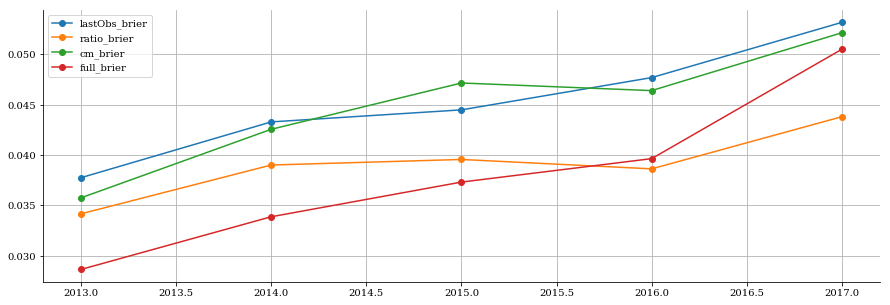

In [16]:
years = df_test['year'].unique()

plt.figure(figsize=[15,5])

plt.plot(years, brier_dict['lastObs_brier'], 'o-', label = 'lastObs_brier')
plt.plot(years, brier_dict['ratio_brier'], 'o-', label = 'ratio_brier')
plt.plot(years, brier_dict['cm_brier'], 'o-', label = 'cm_brier')
plt.plot(years, brier_dict['full_brier'], 'o-', label = 'full_brier')


plt.legend()

plt.grid()
sns.despine()
plt.show()

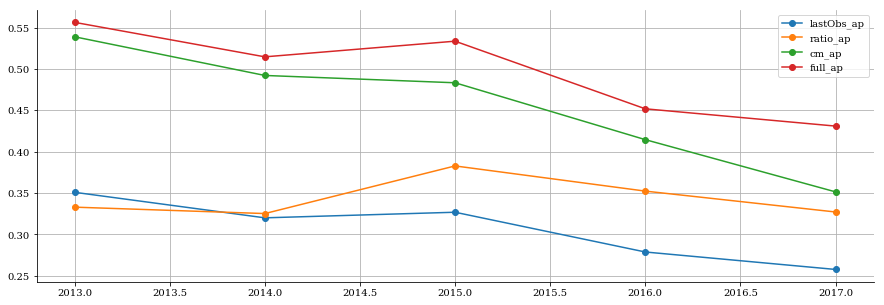

In [17]:
years = df_test['year'].unique()

plt.figure(figsize=[15,5])

plt.plot(years, ap_dict['lastObs_ap'], 'o-', label = 'lastObs_ap')
plt.plot(years, ap_dict['ratio_ap'], 'o-', label = 'ratio_ap')
plt.plot(years, ap_dict['cm_ap'], 'o-', label = 'cm_ap')
plt.plot(years, ap_dict['full_ap'], 'o-', label = 'full_ap')


plt.legend()

plt.grid()
sns.despine()
plt.show()

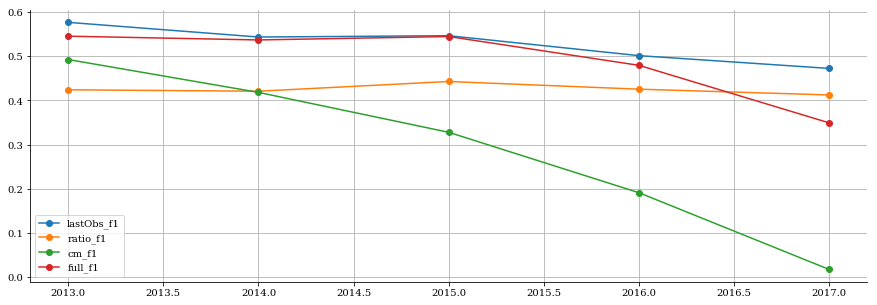

In [18]:
years = df_test['year'].unique()

plt.figure(figsize=[15,5])

plt.plot(years, f1_dict['lastObs_f1'], 'o-', label = 'lastObs_f1')
plt.plot(years, f1_dict['ratio_f1'], 'o-', label = 'ratio_f1')
plt.plot(years, f1_dict['cm_f1'], 'o-', label = 'cm_f1')
plt.plot(years, f1_dict['full_f1'], 'o-', label = 'full_f1')


plt.legend()

plt.grid()
sns.despine()
plt.show()

### looks fine. Onward!

# Old and nice plots. perhaps I need to incorporate the above

In [84]:
baseline_train2012 = df_train[df_train['year']==2012]['binary_best']
years = df_test['year'].unique()

baseline_recall = []
baseline_precision = []
baseline_f1 = []

full_precision = []
full_recall = []
full_f1 = []

threshold = 0.5
                
for i in years:
    y = df_test[df_test['year'] == i]['binary_best']
    baseline_recall.append(recall_score(y, baseline_train2012))
    baseline_precision.append(precision_score(y, baseline_train2012))
    baseline_f1.append(f1_score(y, baseline_train2012))
    
    y_hat = (np.array(dict_of_dicts[str(i)]['preds_bayes']).mean(axis = 0) >= threshold) * 1
    full_precision.append(recall_score(y, y_hat))
    full_recall.append(precision_score(y, y_hat))
    full_f1.append(f1_score(y, y_hat))


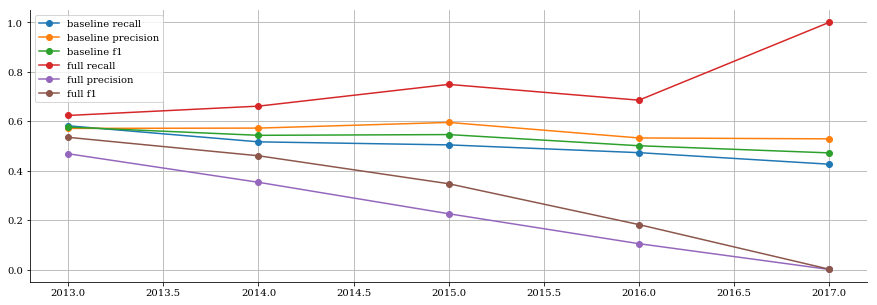

In [85]:
plt.figure(figsize=[15,5])

plt.plot(years, baseline_recall, 'o-', label = 'baseline recall')
plt.plot(years, baseline_precision, 'o-', label = 'baseline precision')
plt.plot(years, baseline_f1, 'o-', label = 'baseline f1')


plt.plot(years, full_recall, 'o-', label = 'full recall')
plt.plot(years, full_precision, 'o-', label = 'full precision')
plt.plot(years, full_f1, 'o-', label = 'full f1')


plt.legend()

plt.grid()
sns.despine()
plt.show()

# simply must be due to the great unbalance of the data!
nothing else make sense..

- [0,0] true negatives
- [1,0] false negatives
- [1,1] true positives
- [0,1] false positives

In [215]:
years = df_test['year'].unique()
y_hat_base = df_train[df_train['year']==2012]['binary_best']

baseline_tn = []
baseline_fn = []
baseline_tp = []
baseline_fp = []


full_tn = []
full_fn = []
full_tp = []
full_fp = []

threshold = 0.1
                
for i in years:
    y = df_test[df_test['year'] == i]['binary_best']
    y_hat_full = (np.array(dict_of_dicts[str(i)]['preds_bayes']).mean(axis = 0) >= threshold) * 1

    
    baseline_tn.append(confusion_matrix(y,y_hat_base)[0,0])
    baseline_fn.append(confusion_matrix(y,y_hat_base)[1,0])
    baseline_tp.append(confusion_matrix(y,y_hat_base)[1,1])
    baseline_fp.append(confusion_matrix(y,y_hat_base)[0,1])

    full_tn.append(confusion_matrix(y,y_hat_full)[0,0])
    full_fn.append(confusion_matrix(y,y_hat_full)[1,0])
    full_tp.append(confusion_matrix(y,y_hat_full)[1,1])
    full_fp.append(confusion_matrix(y,y_hat_full)[0,1])


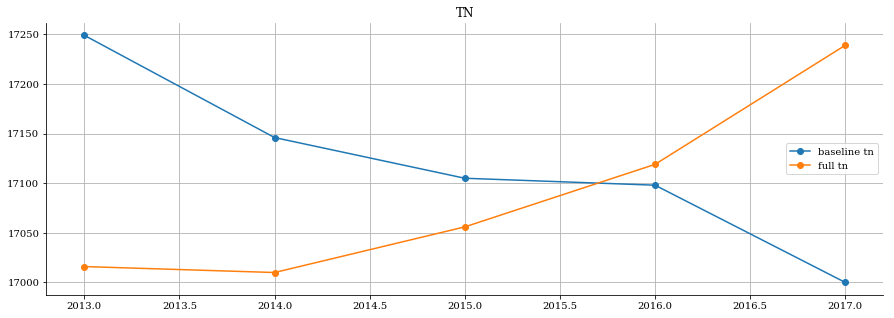

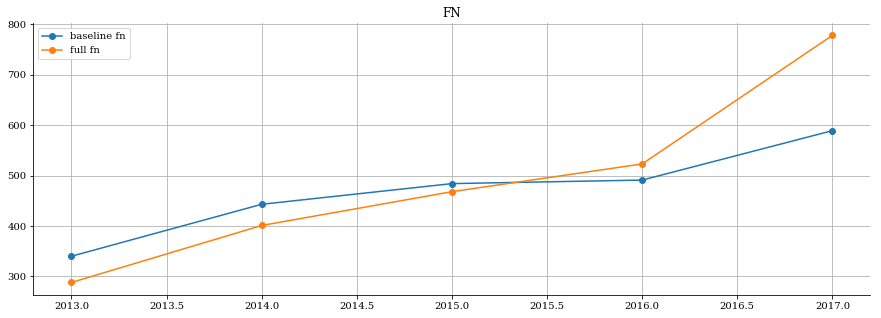

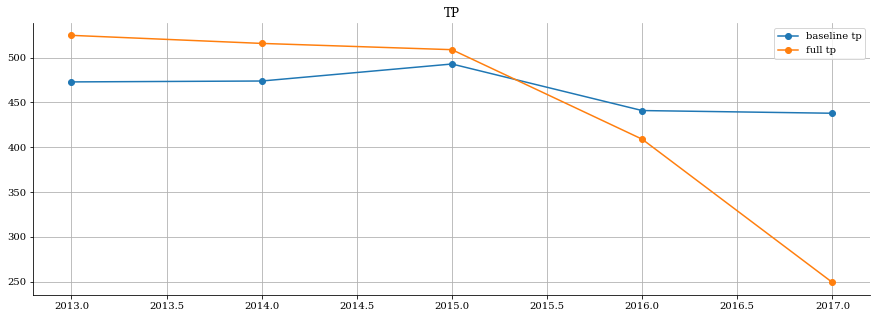

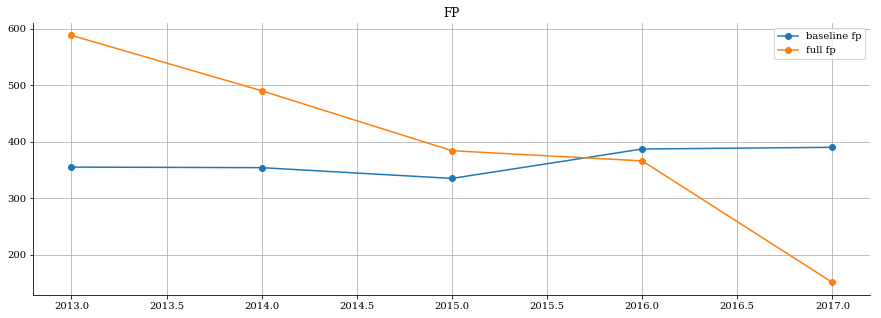

In [216]:
# TN
plt.figure(figsize=[15,5])
plt.plot(years, baseline_tn, 'o-', label = 'baseline tn')
plt.plot(years, full_tn, 'o-', label = 'full tn')

plt.legend()
plt.title('TN')

plt.grid()
sns.despine()
plt.show()

# FN
plt.figure(figsize=[15,5])
plt.plot(years, baseline_fn, 'o-', label = 'baseline fn')
plt.plot(years, full_fn, 'o-', label = 'full fn')

plt.legend()
plt.title('FN')

plt.grid()
sns.despine()
plt.show()

# TP
plt.figure(figsize=[15,5])
plt.plot(years, baseline_tp, 'o-', label = 'baseline tp')
plt.plot(years, full_tp, 'o-', label = 'full tp')

plt.legend()
plt.title('TP')

plt.grid()
sns.despine()
plt.show()

# FP
plt.figure(figsize=[15,5])
plt.plot(years, baseline_fp, 'o-', label = 'baseline fp')
plt.plot(years, full_fp, 'o-', label = 'full fp')


plt.legend()
plt.title('FP')

plt.grid()
sns.despine()
plt.show()

# baseline temporal dimension vs full model:

In [124]:
def logit(z):
    a = 1/(1+np.exp(-z))
    
    return(a)

def baysian_correction(a):
    
    ones = df_train['binary_best'].sum()/df_train['binary_best'].shape[0]
    zeroes = 1 - (df_train['binary_best'].sum()/df_train['binary_best'].shape[0])
    
    y_hat =  (a*ones)/((a*ones)+((1-a)*zeroes))
    return(y_hat)

In [146]:
cm_mu = df_test['cm_mu']
cm_logit = logit(cm_mu)
cm_bayes = baysian_correction(cm_logit)
cm_baseline = pd.DataFrame([cm_logit,cm_bayes,df_test['year']]).T
cm_baseline.columns = ['cm_logit','cm_bayes','year'] 

In [152]:
years = df_test['year'].unique()

cmlogit_recall = []
cmlogit_precision = []
cmlogit_f1 = []

cmb_recall = []
cmb_precision = []
cmb_f1 = []

threshold = 0.1
                
for i in years:
    y = df_test[df_test['year'] == i]['binary_best']
    
    yl_hat = (cm_baseline[cm_baseline['year']==i]['cm_logit'] >= threshold) * 1
    cmlogit_recall.append(recall_score(y, yl_hat))
    cmlogit_precision.append(precision_score(y, yl_hat))
    cmlogit_f1.append(f1_score(y, yl_hat))
    
    yb_hat = (cm_baseline[cm_baseline['year']==i]['cm_bayes'] >= threshold) * 1
    cmb_recall.append(recall_score(y, yb_hat))
    cmb_precision.append(precision_score(y, yb_hat))
    cmb_f1.append(f1_score(y, yb_hat))


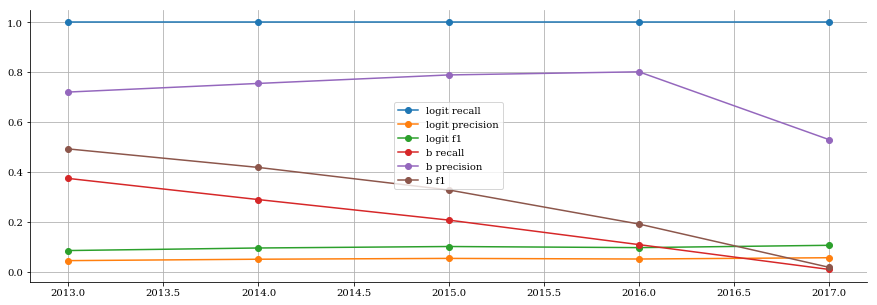

In [153]:
plt.figure(figsize=[15,5])

plt.plot(years, cmlogit_recall, 'o-', label = 'logit recall')
plt.plot(years, cmlogit_precision, 'o-', label = 'logit precision')
plt.plot(years, cmlogit_f1, 'o-', label = 'logit f1')


plt.plot(years, cmb_recall, 'o-', label = 'b recall')
plt.plot(years, cmb_precision, 'o-', label = 'b precision')
plt.plot(years, cmb_f1, 'o-', label = 'b f1')


plt.legend()

plt.grid()
sns.despine()
plt.show()

### so the bays correction makes a lot of sense.
on to test against full model:

In [209]:
baseline_train2012 = df_train[df_train['year']==2012]['binary_best']
years = df_test['year'].unique()

cmb_recall = []
cmb_precision = []
cmb_f1 = []

full_precision = []
full_recall = []
full_f1 = []

threshold = 0.1
                
for i in years:
    y = df_test[df_test['year'] == i]['binary_best']

    yb_hat = (cm_baseline[cm_baseline['year']==i]['cm_bayes'] >= threshold) * 1
    cmb_recall.append(recall_score(y, yb_hat))
    cmb_precision.append(precision_score(y, yb_hat))
    cmb_f1.append(f1_score(y, yb_hat))
    
    
    yf_hat = (np.array(dict_of_dicts[str(i)]['preds_bayes']).mean(axis = 0) >= threshold) * 1
    full_precision.append(recall_score(y, yf_hat))
    full_recall.append(precision_score(y, yf_hat))
    full_f1.append(f1_score(y, yf_hat))


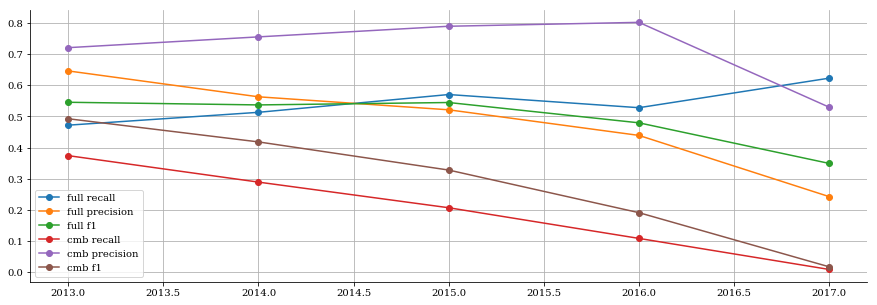

In [210]:
plt.figure(figsize=[15,5])

plt.plot(years, full_recall, 'o-', label = 'full recall')
plt.plot(years, full_precision, 'o-', label = 'full precision')
plt.plot(years, full_f1, 'o-', label = 'full f1')


plt.plot(years, cmb_recall, 'o-', label = 'cmb recall')
plt.plot(years, cmb_precision, 'o-', label = 'cmb precision')
plt.plot(years, cmb_f1, 'o-', label = 'cmb f1')


plt.legend()

plt.grid()
sns.despine()
plt.show()

# f1 for all:

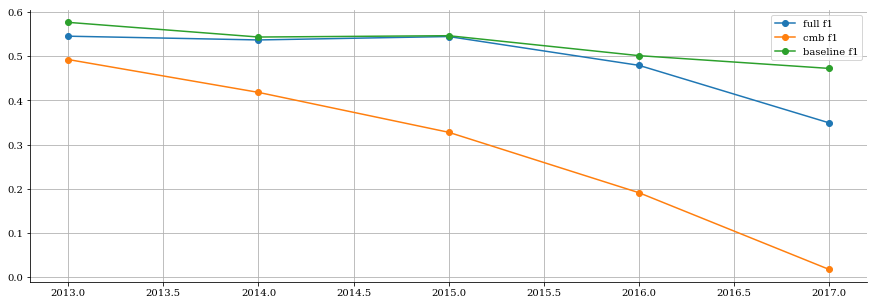

In [211]:
plt.figure(figsize=[15,5])

plt.plot(years, full_f1, 'o-', label = 'full f1')
plt.plot(years, cmb_f1, 'o-', label = 'cmb f1')
plt.plot(years, baseline_f1, 'o-', label = 'baseline f1')


plt.legend()

plt.grid()
sns.despine()
plt.show()

# that is fuking strange.. Is unbalance to blame???

In [225]:
years = df_test['year'].unique()
baseline_train2012 = df_train[df_train['year']==2012]['binary_best']

base_ap = []
cm_ap = []
full_ap = []
    
for i in years:
    y = df_test[df_test['year'] == i]['binary_best']
    yb_hat = cm_baseline[cm_baseline['year']==i]['cm_bayes']
        
    cm_ap.append(average_precision_score(y,yb_hat))
    base_ap.append(average_precision_score(y,baseline_train2012))
    full_ap.append(dict_of_dicts[str(i)]['mean_ap'])

In [226]:
def ap_trend(fig_title):

    ap_means = []
    ap_highs = []
    ap_lows = []
    years = []

    for i in np.arange(2013,2018,1):
        ap_means.append(dict_of_dicts[str(i)]['mean_ap'])
        ap_highs.append(dict_of_dicts[str(i)]['high_ap'])
        ap_lows.append(dict_of_dicts[str(i)]['low_ap'])

        years.append(i)


    plt.figure(figsize=[13,5])

    plt.plot(years,ap_means, '-o', label = 'full ap')
    plt.plot(years, cm_ap, 'o-', label = 'cm ap')
    plt.plot(years, base_ap, 'o-', label = 'base ap')

    plt.fill_between(years, ap_highs, ap_lows, color = 'lightgray', alpha = 0.5)

    plt.vlines(2012+3,0,0.6,color='darksalmon', linestyle='dashed',alpha = 0.8)

    plt.xticks(years)

    plt.xlim(2013,2017)
    plt.ylim(0.25,0.6)

#     plt.savefig(fig_title, bbox_inches="tight")

    plt.legend()
    plt.grid()
    sns.despine()
    plt.show()

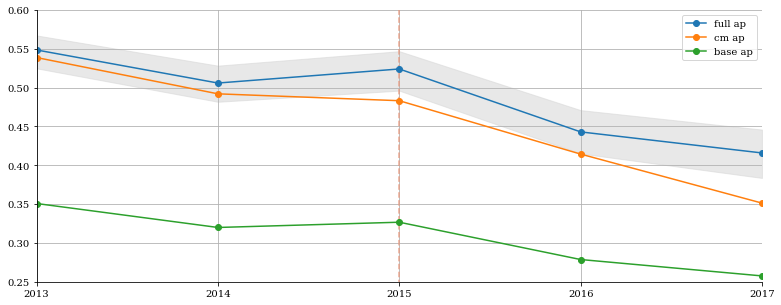

In [227]:
ap_trend('test')

# So, it might be do to unbalance.. That would be nice. But can you truely use ap when baseline is binary?

### Brier score?

In [238]:
years = df_test['year'].unique()
baseline_train2012 = df_train[df_train['year']==2012]['binary_best']

base_brier = []
cm_brier = []
full_brier= []
    
for i in years:
    y = df_test[df_test['year'] == i]['binary_best']
    yb_hat = cm_baseline[cm_baseline['year']==i]['cm_bayes']
    y_hat_full = np.array(dict_of_dicts[str(i)]['preds_bayes']).mean(axis = 0)
        
    cm_brier.append(brier_score_loss(y,yb_hat))
    base_brier.append(brier_score_loss(y,baseline_train2012))
    full_brier.append(brier_score_loss(y,y_hat_full))

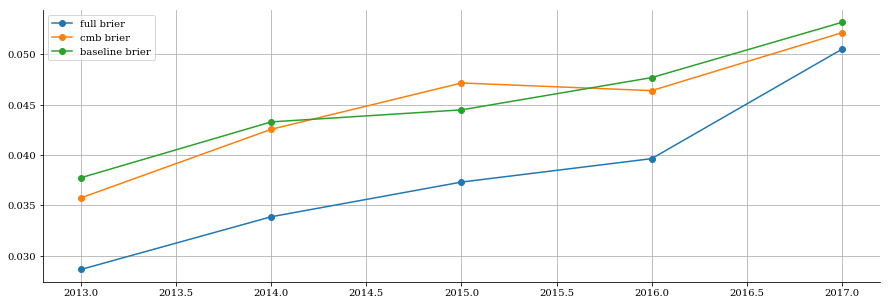

In [239]:
plt.figure(figsize=[15,5])

plt.plot(years, full_brier, 'o-', label = 'full brier')
plt.plot(years, cm_brier, 'o-', label = 'cmb brier')
plt.plot(years, base_brier, 'o-', label = 'baseline brier')


plt.legend()

plt.grid()
sns.despine()
plt.show()

# so you are also doing better on brier... Phy.. but is it prober to use the binary base here?
Well, that was not the purpose for the measures brier and ap, but it is predictions. just only 100% and 0% predictions. Wich is also all we get from the knowledge from last year. Else you should use an exponetialle wieted average, but you would have to come up with ${\beta}$, and that is exactly the point: you don't want to.
... That being said.. Now you have ${\ell}$ maybe it could beused as a proxy if you need to do something very fast? idk.

# old and working

In [3]:
def ap_score(fig_title):

    plt.figure(figsize=[13,5])

    test_years = np.arange(2013,2018,1)
    colors = sns.color_palette("hls", test_years.shape[0])
    # colors = sns.hls_palette(8, l=.5, s=.5)

    for i, j in enumerate(test_years):
        point_est = np.mean(dict_of_dicts[str(j)]['ap'])

        plot = sns.kdeplot(dict_of_dicts[str(j)]['ap'], 
                           color = colors[i], label = f'{j}')# point est.: {round(point_est,2)}')

        x, y = plot.lines[i].get_data()        
        plt.vlines(point_est, max(y) - 3, max(y) + 3, color = colors[i])
        plt.annotate(f'{round(point_est,2)}', (point_est+0.002, max(y)),
                     color = colors[i], fontsize = 14)

    plt.ylim(0,55)
    plt.xlim(0.35,0.60)
    plt.xticks(fontsize = 12)
    plt.yticks([], fontsize = 12)

    plt.legend(loc=2, fontsize = 14)
    plt.title('Average precision scores\n(out-of-sample)', fontsize = 16)
    plt.xlabel('Average precision', fontsize = 14)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

/home/polichinel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


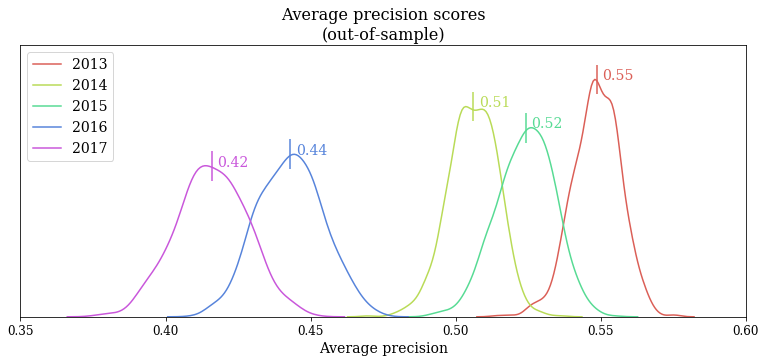

In [4]:
ap_score('ap_scores.pdf')

In [5]:
sum(np.array(dict_of_dicts['2014']['ap']) <= np.array(dict_of_dicts['2016']['ap']))/1000

0.0

In [6]:
sum(np.array(dict_of_dicts['2015']['ap']) <= np.array(dict_of_dicts['2016']['ap']))/1000

0.0

In [7]:
sum(np.array(dict_of_dicts['2015']['ap']) >= np.array(dict_of_dicts['2013']['ap']))/1000

0.024

In [8]:
sum(np.array(dict_of_dicts['2015']['ap']) >= np.array(dict_of_dicts['2014']['ap']))/1000

0.893

In [9]:
def ap_trend(fig_title):

    ap_means = []
    ap_highs = []
    ap_lows = []
    years = []

    for i in np.arange(2013,2018,1):
        ap_means.append(dict_of_dicts[str(i)]['mean_ap'])
        ap_highs.append(dict_of_dicts[str(i)]['high_ap'])
        ap_lows.append(dict_of_dicts[str(i)]['low_ap'])

        years.append(i)


    plt.figure(figsize=[13,5])

    plt.plot(years,ap_means, '-o', color = 'C1')
    plt.fill_between(years, ap_highs, ap_lows, color = 'lightgray', alpha = 0.5)

    plt.vlines(2012+3,0,0.6,color='darksalmon', linestyle='dashed',alpha = 0.8)

    plt.xticks(years)

    plt.xlim(2013,2017)
    plt.ylim(0.35,0.6)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

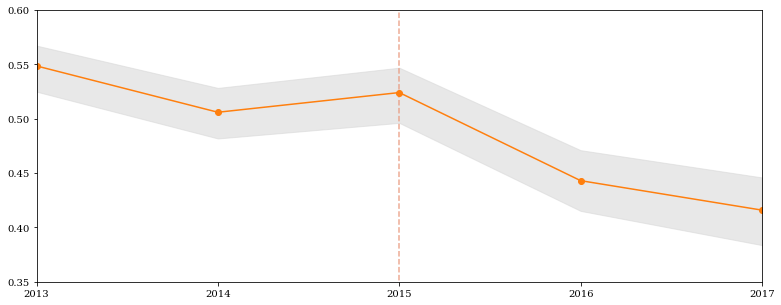

In [10]:
ap_trend('ap_trend.pdf')

In [11]:
def ap_trend_alt(fig_title):

    years = list(dict_of_dicts.keys())
    ap_means = []
    plt.figure(figsize=[13,5])


    for i in np.arange(0,1000,1):
        list_of_ap = [] 
        for year in years:
            list_of_ap.append(dict_of_dicts[year]['ap'][i])

        plt.plot(years, list_of_ap, color='C0', alpha=0.01)

    for i in np.arange(2013,2018,1):
        ap_means.append(dict_of_dicts[str(i)]['mean_ap'])

    plt.plot(years, ap_means, '-o', color = 'C1')
    
    plt.vlines(years[2],0,0.6,color='darksalmon', linestyle='dashed',alpha = 0.8)

    
    cred_label = "Average precision 1000 samples"
    mean_label = 'Average precision point estimat (mean)'
    cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)
    mean_line = mlines.Line2D([], [], color='C1', marker='o', markersize=15, label=mean_label)
    plt.legend(handles=[mean_line, cred_line],frameon = False, fontsize = 14)

    plt.title('Average precision trend\n(out-of-sample)', fontsize = 16)
    plt.xlabel('years', fontsize = 14)
    plt.ylabel('AP', fontsize = 14)
    
    plt.xlim(years[0],years[-1])
    plt.ylim(0.35,0.6)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.savefig(fig_title, bbox_inches="tight")
    

    plt.show()

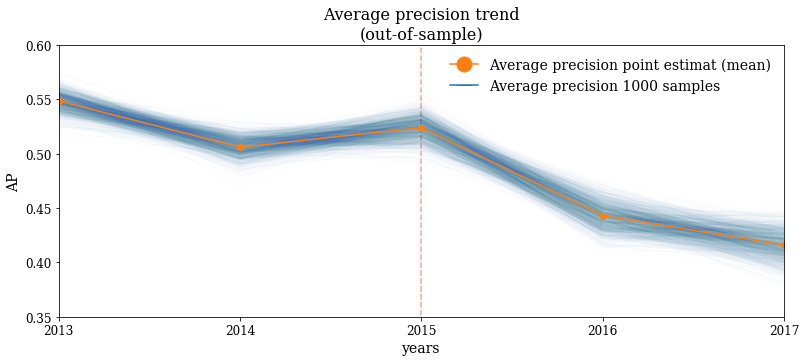

In [12]:
ap_trend_alt('ap_trend_alt.pdf')

In [13]:
df_test[df_test['year']==2014]['binary_best'].sum()/df_test[df_test['year']==2014]['binary_best'].shape

array([0.04979095])

In [14]:
df_test[df_test['year']==2015]['binary_best'].sum()/df_test[df_test['year']==2015]['binary_best'].shape

array([0.05304881])

In [15]:
def pr_curve(fig_title, year):
    
    baseline = df_test[df_test['year']==year]['binary_best'].sum()/df_test[df_test['year']==year]['binary_best'].shape
    
    dict_of_metrics = dict_of_dicts[str(year)]

    plt.figure(figsize=[9,9])

    for i in np.arange(0,1000,1):
        plt.plot(dict_of_metrics['recall'][i], dict_of_metrics['precision'][i], color='C0', alpha=0.01)

    mean_ap = dict_of_metrics['mean_ap']
    high_ap = dict_of_metrics['high_ap']
    low_ap = dict_of_metrics['low_ap']

    plt.plot(dict_of_metrics['recall_mean'], dict_of_metrics['precision_mean'], color='C1', alpha=1)
    plt.hlines(baseline, 0, 1, color='gray', linestyle='--')

    
    plt.title(f'Precision-Recall Curve {year}', fontsize = 16)
    
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])

    sns.despine()

    cred_label = "Average precision 99% credibility interval: " + str(low_ap.round(3)) + '-' + str(high_ap.round(2))
    mean_label = 'Average precision point estimat (mean): ' + str(mean_ap.round(3))
    random_label = '"Random" baseline'

    cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

    mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)
    
    random_line = mlines.Line2D([], [], color='gray', marker='_', markersize=15, label=random_label)

    plt.legend(handles=[mean_line, cred_line, random_line],frameon = False, fontsize = 14)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()


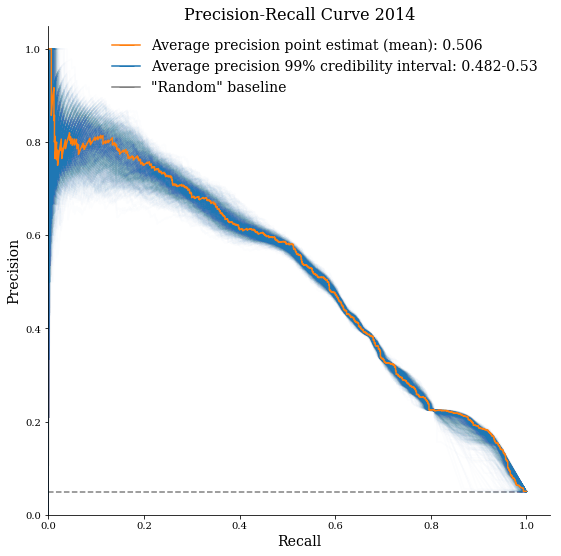

In [16]:
pr_curve('PR_2014.pdf', 2014)

In [17]:
# years  = [2014,2015]

def pr_curves(fig_title, years):

    fig, axes = plt.subplots(1, len(years), sharey=False,figsize=(13,5))

    for i, j in enumerate(years):
        baseline = df_test[df_test['year']==j]['binary_best'].sum()/df_test[df_test['year']==j]['binary_best'].shape

        dict_of_metrics = dict_of_dicts[str(j)]  
        mean_ap = dict_of_metrics['mean_ap']
        high_ap = dict_of_metrics['high_ap']
        low_ap = dict_of_metrics['low_ap']

    #     mean_auc =  np.mean(dict_of_metrics['auc'])
    #     high_auc = np.percentile(np.array(dict_of_metrics['auc']),97.5)
    #     low_auc = np.percentile(np.array(dict_of_metrics['auc']),2.5)


        for n in np.arange(0,1000,1):
            axes[i].plot(dict_of_metrics['recall'][n], dict_of_metrics['precision'][n], color='C0', alpha=0.01)

        axes[i].plot(dict_of_metrics['recall_mean'], dict_of_metrics['precision_mean'], color='C1', alpha=1)
        axes[i].hlines(baseline, 0, 1, color='gray', linestyle='--')
        axes[i].set_title(f'{j}', fontsize = 14)

        cred_label = f'AP 99% cred. int.: {low_ap.round(2)} - {high_ap.round(2)}'
        mean_label = f'AP point est.: {mean_ap.round(2)}'
        random_label = '"Random" baseline'

        cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)
        mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)
        random_line = mlines.Line2D([], [], color='gray', marker='_', markersize=15, label=random_label)


        axes[i].legend(handles=[mean_line, cred_line, random_line], frameon = False, fontsize = 14, loc = 1)

    #     auc_text = f'ROC-AUC point est.: {mean_auc.round(2)}\nROC-AUC 99% credibility int.: {low_auc.round(2)} - {high_auc.round(2)}'

    #     axes[i].annotate(auc_text,(0.05,0.1), fontsize = 14)

        axes[i].set_xlabel('Recall', fontsize = 14)
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlim([0.0, 1.05])
        
        axes[i].set_xticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)


        if i == 0:
            axes[i].set_ylabel('Precision', fontsize = 14)
            axes[i].set_yticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)

            
        else:
            axes[i].set_ylabel('')
            axes[i].set_yticklabels([],fontsize=12)


    fig.suptitle('Precision-Recall Curves', fontsize = 16)    

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

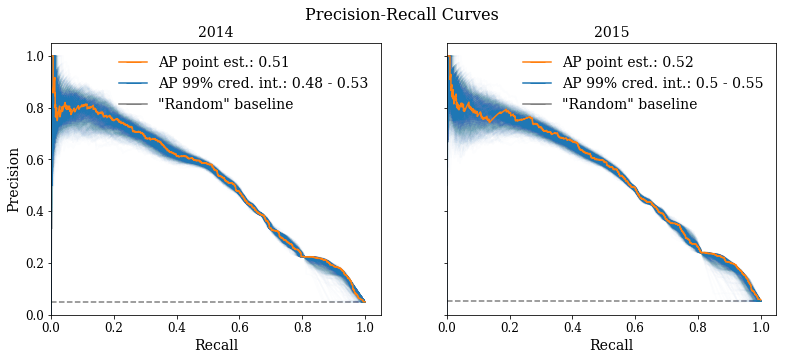

In [18]:
pr_curves('pr_curves_14_15.pdf', [2014,2015])

In [19]:
# pkl_file = open('xgboost_dict_of_dicts_new.pkl', 'rb')
# dict_of_dicts = pickle.load(pkl_file)
# pkl_file.close()

In [20]:
def roc_curves(fig_title, years):

    fig, axes = plt.subplots(1, len(years), sharey=False,figsize=(13,5))

    for i, j in enumerate(years):

        dict_of_metrics = dict_of_dicts[str(j)]  

        mean_auc = np.mean(dict_of_metrics['auc'])
        high_auc = np.percentile(np.array(dict_of_metrics['auc']),99.5)
        low_auc = np.percentile(np.array(dict_of_metrics['auc']),00.5) 

        for n in np.arange(0,1000,1): #1000
            axes[i].plot(dict_of_metrics['fpr'][n], dict_of_metrics['tpr'][n], color='C0', alpha=0.01)

        axes[i].plot(dict_of_metrics['fpr_mean'], dict_of_metrics['tpr_mean'], color='C1', alpha=1)
        axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[i].set_title(f'{j}', fontsize = 14)

        cred_label = f'AUC 99% cred. int.: {low_auc.round(2)} - {high_auc.round(2)}'
        mean_label = f'AUC point est.: {mean_auc.round(2)}'
        random_label = '"Random" baseline'


        cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

        mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)

        random_line = mlines.Line2D([], [], color='gray', marker='_', markersize=15, label=random_label)

        axes[i].legend(handles=[mean_line, cred_line, random_line], frameon = False, fontsize = 14, loc = 4)

    
    #     auc_text = f'ROC-AUC point est.: {mean_auc.round(2)}\nROC-AUC 99% credibility int.: {low_auc.round(2)} - {high_auc.round(2)}'

    #     axes[i].annotate(auc_text,(0.05,0.1), fontsize = 14)

        axes[i].set_xlabel('False positive rate', fontsize = 14)
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlim([0.0, 1.05])
        
        axes[i].set_xticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)


        if i == 0:
            axes[i].set_ylabel('True positive rate', fontsize = 14)
            axes[i].set_yticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)

            
        else:
            axes[i].set_ylabel('')
            axes[i].set_yticklabels([],fontsize=12)


    fig.suptitle('ROC Curves', fontsize = 16)    

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

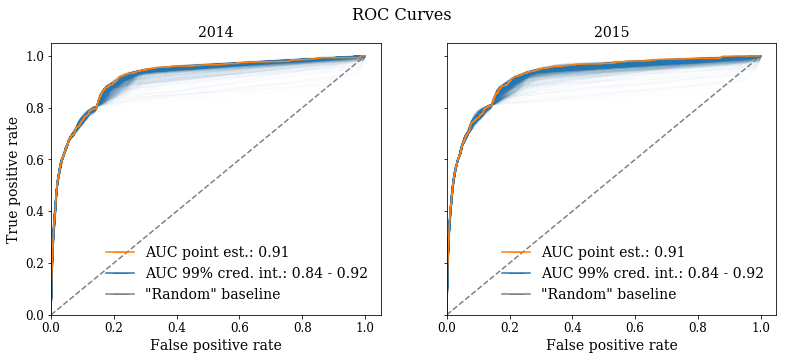

In [21]:
roc_curves('roc_curves_14_15.pdf', [2014,2015])

In [33]:
def prob_map(year):
    df_test_sub_ = df_test[df_test['year']==year].copy()
    df_test_sub_['predsB'] = dict_of_dicts[str(year)]['mean_preds']
    df_test_sub_.plot(column = 'predsB', figsize=[15,5], vmin = 0, vmax = 1, legend=True)
    
    # need predefined min, max and colorbar!
    
    plt.ylim(-10,50)
    plt.xlim(-20,100)
    plt.xlabel('longitude', fontsize = 14)
    plt.ylabel('latitude', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.title(f'Estimated probabilities of conflict: {year}', fontsize = 16)
  
    fig_title = f'prop_map_{year}.pdf'
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

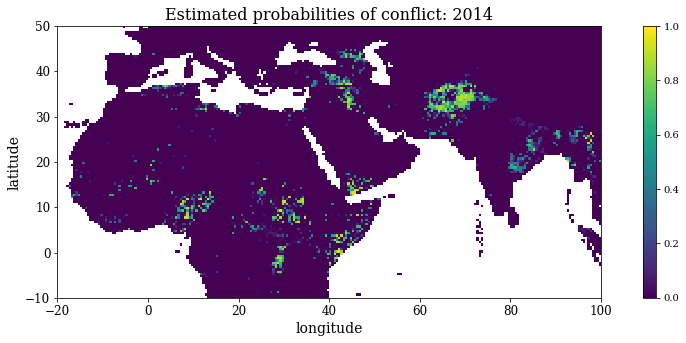

In [34]:
prob_map(2014)

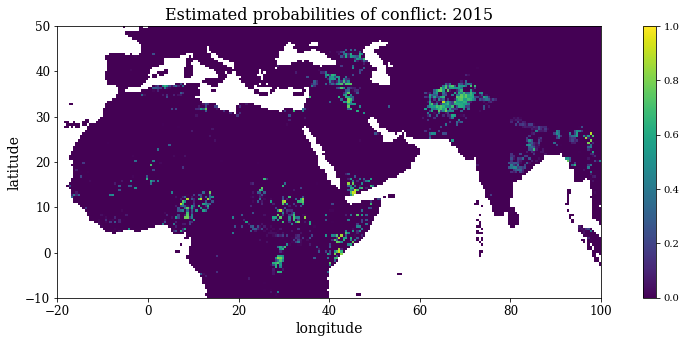

In [35]:
prob_map(2015)

In [47]:
def confusion_map(year, threshold):
    viridis = cm.get_cmap('viridis', 4)
    
    sub_df_test = df_test[df_test['year']==year].copy()
    sub_df_test['predsB'] = dict_of_dicts[str(year)]['mean_preds']

    binary_pred = (sub_df_test['predsB']>threshold)*1 # should be 0.15 to match posterior of 2012 (last observed year) distrbution with actually output
    sub_df_test['binary_pred'] =  binary_pred
    
    sub_df_test['TP'] = ((sub_df_test['binary_pred'] == 1) & (sub_df_test['binary_best'] == 1))*1
    sub_df_test['TN'] = ((sub_df_test['binary_pred'] == 0) & (sub_df_test['binary_best'] == 0))*1
    sub_df_test['FP'] = ((sub_df_test['binary_pred'] == 1) & (sub_df_test['binary_best'] == 0))*1
    sub_df_test['FN'] = ((sub_df_test['binary_pred'] == 0) & (sub_df_test['binary_best'] == 1))*1

    cats_list = ['TN','TP','FP','FN']

    plt.figure(figsize=[13.8,7])

#     colors = ['lightgrey','salmon','teal','crimson']
#     colors = ['lightsteelblue','indianred','steelblue','maroon']
#     colors = ['steelblue','maroon','lightsteelblue','indianred']

    colors = [viridis.colors[0],viridis.colors[3],viridis.colors[1],viridis.colors[2]]


    labels = ['true negatives', 'true positives', 'false positives', 'false negatives']

    for i, j in enumerate(cats_list):
        X = np.array([sub_df_test[sub_df_test[j]==1]['xcoord'], sub_df_test[sub_df_test[j]==1]['ycoord']]).T

        plt.scatter(X[:,0], X[:,1], s=9, c = colors[i], marker='s', label = labels[i])

    plt.ylim(-10,50)
    plt.xlim(-20,100)
    plt.xlabel('longitude', fontsize = 14)
    plt.ylabel('latitude', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
        
    plt.title('Predictions {}\n Last year included i model: 2012\nThreshold: {}% probability of conflict'.format(year,threshold * 100)
              , fontsize = 16)
    plt.legend(fontsize = 14)

    fig_title = 'confusion_map_{}.pdf'.format(year)
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()
    
    recall = sub_df_test['TP'].sum()/(sub_df_test['TP'].sum()+sub_df_test['FP'].sum())
    precision = sub_df_test['TP'].sum()/(sub_df_test['TP'].sum()+sub_df_test['FN'].sum())
    
    print(f'{year}\nrecall: {recall}\nprecision: {precision}')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

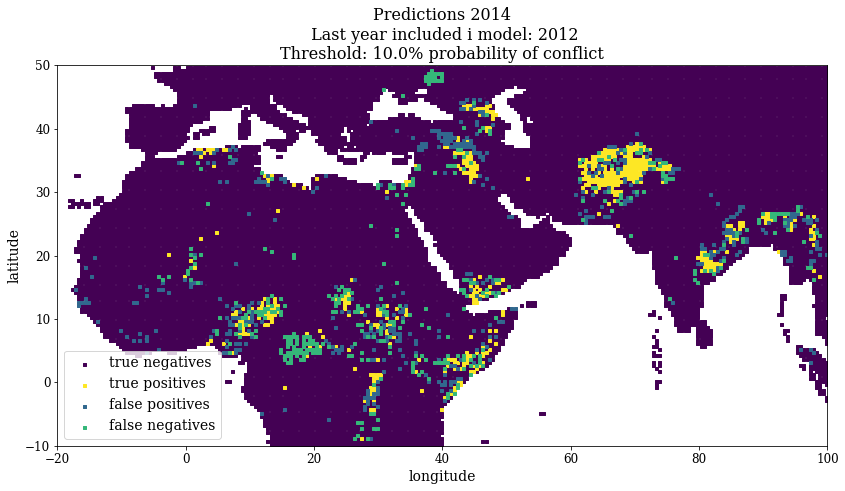

2014
recall: 0.5129224652087475
precision: 0.5627044711014176


In [48]:
confusion_map(2014,0.10)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

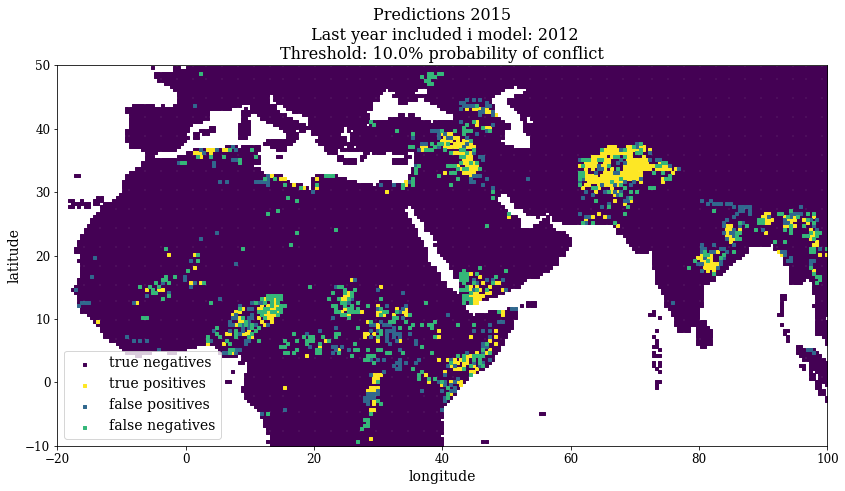

2015
recall: 0.5699888017917133
precision: 0.5209825997952917


In [49]:
confusion_map(2015,0.10)

In [80]:
def feature_imp(year):

    dict_of_metrics = dict_of_dicts[str(year)]  


    importances = np.array(dict_of_metrics['feature_imp']).mean(0)
    importances_std = np.array(dict_of_metrics['feature_imp']).std(0)


    indices = np.argsort(importances)[::-1]

    size = len(importances)

    plt.figure(figsize=[10,int(size)*0.75])

    plt.title("Feature importances" + f'\n({year})', fontsize = 16)


    plt.barh(range(size), importances[indices], color="salmon", align="center", yerr=importances_std[indices])

#     X_labels = ['dce_mu','cm_mu','dce_slope','cm_slope','dce_acc','cm_acc','cm_mass','dce_mass']
    X_labels = ["$f_{dce}$", "$f_{cm}$", "$f'_{dce}$", "$f'_{cm}$", "$f''_{dce}$", "$f''_{cm}$", "$F_{cm}$", "$F_{dce}$"]

    
    plt.yticks(range(size),  np.array(X_labels)[indices], fontsize = 14)
    plt.ylim([-1, size])

    plt.xlabel('gain', fontsize = 14)
    plt.ylabel('features', fontsize = 14)

    sns.despine()

    fig_title = f'feature_imp_{year}.pdf'
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

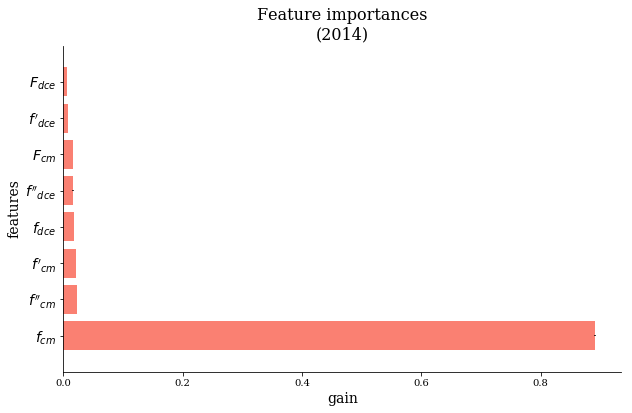

In [84]:
feature_imp(2014)

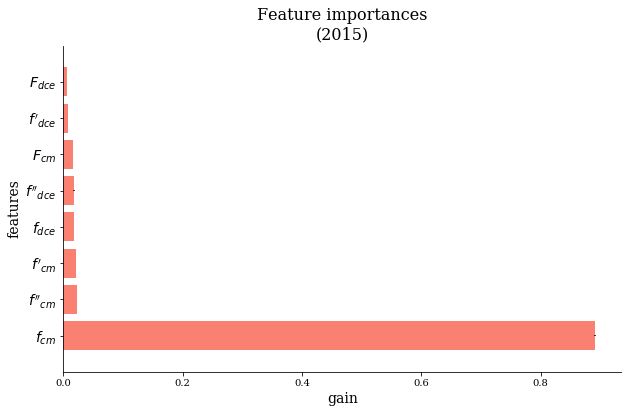

In [83]:
feature_imp(2015)

<Figure size 648x648 with 0 Axes>

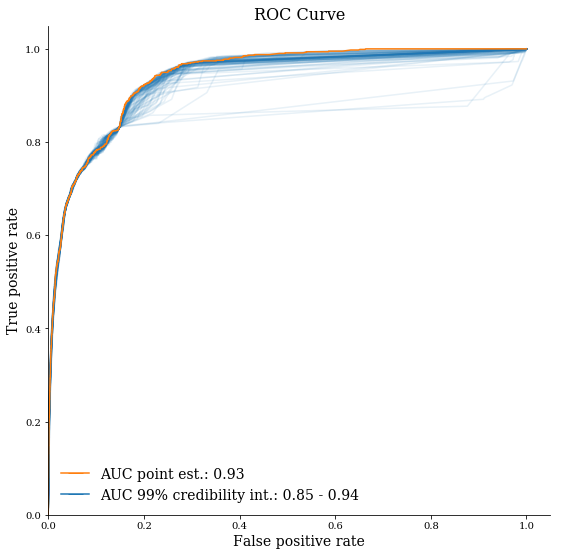

In [143]:
dict_of_metrics = dict_of_dicts['2013']

plt.figure(figsize=[9,9])

for i in np.arange(0,100,1):
    plt.plot(dict_of_metrics['fpr'][i], dict_of_metrics['tpr'][i], color='C0', alpha=0.1)

mean_auc = np.mean(dict_of_metrics['auc'])
high_auc = np.percentile(np.array(dict_of_metrics['auc']),99.5)
low_auc = np.percentile(np.array(dict_of_metrics['auc']),00.5) 
    
plt.plot(dict_of_metrics['fpr_mean'], dict_of_metrics['tpr_mean'], color='C1', alpha=1)

plt.title('ROC Curve', fontsize = 16)
    
plt.xlabel('False positive rate', fontsize = 14)
plt.ylabel('True positive rate', fontsize = 14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

sns.despine()


cred_label = f'AUC 99% credibility int.: {low_auc.round(2)} - {high_auc.round(2)}'
mean_label = f'AUC point est.: {mean_auc.round(2)}'

cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)

plt.legend(handles=[mean_line, cred_line],frameon = False, fontsize = 14)

plt.show()


In [69]:
np.mean(dict_of_metrics['auc'])
np.percentile(np.array(dict_of_metrics['auc']),97.5)
np.percentile(np.array(dict_of_metrics['auc']),2.5)

0.9130714806078802

In [97]:
dict_of_metrics.keys()

dict_keys(['auc', 'ap', 'recall', 'precision', 'preds1', 'preds0', 'preds_bayes', 'feature_imp', 'mean_ap', 'high_ap', 'low_ap', 'recall_mean', 'precision_mean', 'mean_preds'])

In [ ]:
np.array(dict_of_metrics['auc']).percentile

In [ ]:
np.array(dict_of_metrics['auc']).quantile